In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set2')

import nltk
import string
from nltk.corpus import stopwords


In [9]:
domains = [ 'bc', 'bn', 'mz', 'nw', 'tc', 'wb' ]

model_types = [ 'baseline', 'pooling', 'mult' ]


In [259]:
def read_score(model='baseline', subset='bc', metric='micro_f1', subtype='test'):
    '''
    model: baseline, pooling, mult
    subset: which sub dataset to be evaluated
    '''
       
    metric = subtype + '_' + metric
    metric_score = {} 
    metric_score[metric] = 0
    
    if 'pooling_' in model:
        model = 'pool_' + model.split('_')[-1]
    if model == 'mult':
        model = 'mult_private'

    fpath = './experiments/' + model + '/' + subset + '/eval_' + subtype + '_best_metric.txt'

    try:
        with open(fpath, 'r', encoding='utf8') as f:
            for line in f:
                key, val = line.split(':')
                metric_score[key.strip()] = float(val.strip())
    except:
        print('Error, model=>{}, subset=>{}'.format(model, subset))

    if metric:
        return metric_score[metric]
    else:
        return metric_score

    
    
def load_sentences(domain='pool', data_type=['train', 'test', 'valid']):
    sents = None

    for dt in ['train', 'test', 'valid']:
        if dt not in data_type:
            continue
        
        dt_sents = pd.read_csv('./data/' + domain + '/' + dt + '/sentences.txt', sep='\n', header=None)
        if sents is None:
            sents = dt_sents
        else:
            sents = pd.concat([sents, dt_sents], axis=0)

    sents.columns = ['sentence']
    return sents



def cal_sent_len(domain='pool', sub_dataset=['train', 'valid', 'test']):
    sents = load_sentences(domain, sub_dataset)
    
    sent_len_all_domain = pd.Series([ len( sent.split() ) for sent in sents['sentence'] ])
    
    return sent_len_all_domain

  

# 1. Exper I - Domain Adaptation

Error, model=>pool_tc, subset=>tc
Error, model=>pool_wb, subset=>wb


,bc,bn,mz,nw,tc,wb
baseline,68.0402,78.9494,73.1074,81.9051,33.7662,46.2279
pooling,78.4823,79.4258,59.4550,61.2609,0.0000,0.0000
mult,80.7577,80.2572,72.9136,75.5839,66.2116,49.7018


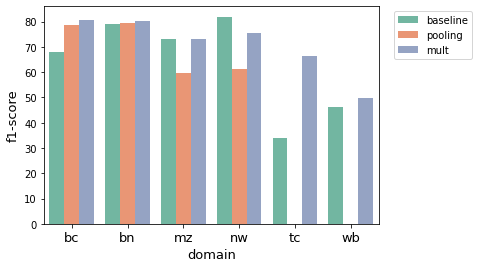

In [282]:
def get_domain_f1_score():
    model_domain_f1 = []

    for model in model_types: # each model
        metric_per_model = [] 
        for d in domains: # each domain
            if model == 'pooling':
                metric_per_model.append( read_score(model=model + '_' + d, subset=d) )
            else:
                metric_per_model.append( read_score(model=model, subset=d) )
        model_domain_f1.append(metric_per_model)

    model_domain_f1 = pd.DataFrame(model_domain_f1, columns=domains, index=model_types)

    return model_domain_f1


def plot_domain_f1_score():
    model_domain_f1_verted = model_domain_f1.reset_index()
    model_domain_f1_verted = pd.melt(model_domain_f1_verted, id_vars=['index'])
    model_domain_f1_verted.columns = ['model', 'domain', 'f1-score']

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(x='domain', y='f1-score', hue='model', data=model_domain_f1_verted, ax=ax)
    ax.legend(bbox_to_anchor=(1.03, 1), loc=2)
    ax.set_xlabel('domain', fontsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.set_ylabel('f1-score', fontsize=13)

plot_domain_f1_score()
model_domain_f1 = get_domain_f1_score()
model_domain_f1


#  Domain Analysis - Seq Len

In [117]:
# in_domain_split_type = ['train', 'valid', 'test']
in_domain_split_type = ['train']

sents_per_domain = []
sent_len_per_domain = []
for d in domains:
    sents = load_sentences(d, in_domain_split_type)
    sents_per_domain.append( sents )
    sent_len_per_domain.append([ len( sent.split() ) for sent in sents['sentence'] ])


median_sent_len_per_domain = [ np.median( s ) for s in sent_len_per_domain ]
min_sent_len_per_domain = [ np.min( s ) for s in sent_len_per_domain ]
max_sent_len_per_domain = [ np.max( s ) for s in sent_len_per_domain ]


In [118]:
median_sent_len_per_domain, min_sent_len_per_domain, max_sent_len_per_domain


([12.0, 17.0, 22.0, 24.0, 6.0, 20.0],
 [2, 2, 2, 2, 2, 2],
 [100, 145, 133, 210, 89, 220])

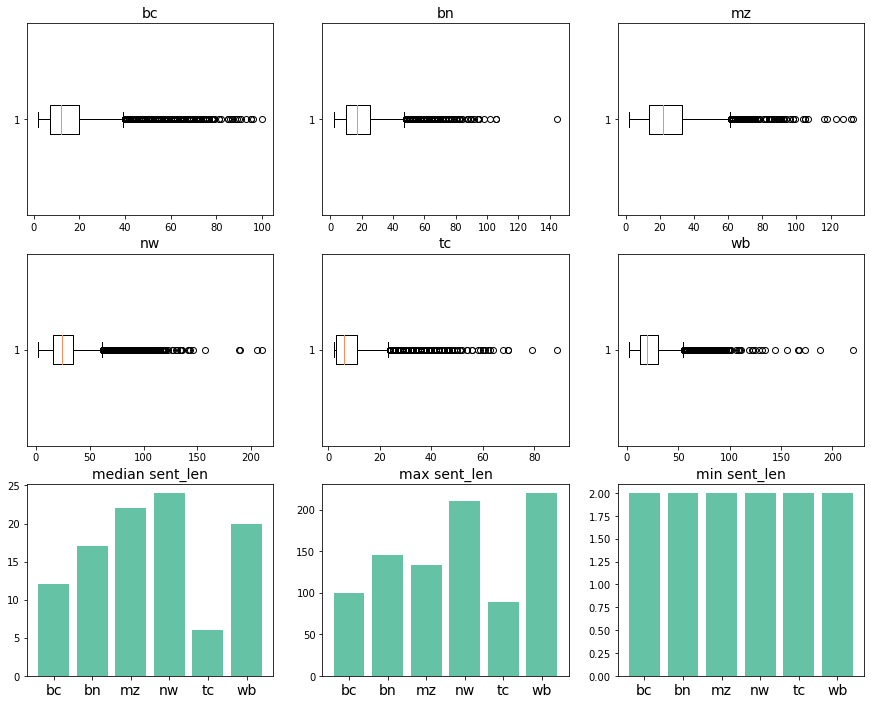

In [119]:
fig, ax = plt.subplots(3, 3, figsize=(15, 12))

for i, d in enumerate(domains):
    ax[i//3,i%3].boxplot(x=sent_len_per_domain[i], vert=False)
    ax[i//3,i%3].set_title(d, fontsize=14)


ax[2, 0].bar(x=domains, height=median_sent_len_per_domain)
ax[2, 0].set_title('median sent_len', fontsize=14)
# ax[2,0].set_xlabel('domain', fontsize=14)
# ax[2,0].set_ylabel('avg sent_len', fontsize=14)
ax[2, 0].xaxis.set_tick_params(labelsize=14)

ax[2,1].bar(x=domains, height=max_sent_len_per_domain)
ax[2,1].set_title('max sent_len', fontsize=14)
# ax[2,1].set_xlabel('domain', fontsize=14)
# ax[2,1].set_ylabel('max sent_len', fontsize=14)
ax[2,1].xaxis.set_tick_params(labelsize=14)


ax[2,2].bar(x=domains, height=min_sent_len_per_domain)
ax[2,2].set_title('min sent_len', fontsize=14)
# ax[2,2].set_xlabel('domain', fontsize=14)
# ax[2,2].set_ylabel('min sent_len', fontsize=14)
ax[2,2].xaxis.set_tick_params(labelsize=14)


plt.show()

## Upper IQR Seq Len

In [120]:
seq_len_upper_IQR_per_domain = []
for v in sent_len_per_domain:
    q75, q25 = np.percentile(v, [75 ,25])
    upper_iqr = 1.5 * (q75 - q25) + q75
    seq_len_upper_IQR_per_domain.append(upper_iqr)

seq_len_upper_IQR_per_domain

[39.5, 47.5, 61.5, 61.0, 23.0, 55.5]

[518, 350, 161, 1069, 595, 571]


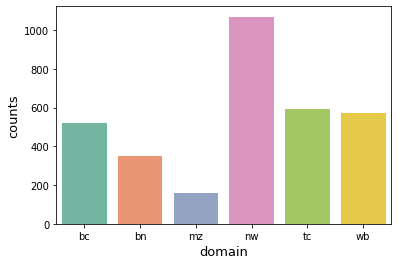

In [142]:
counts_above_per_domain = [ sum(np.array(sent_len_per_domain[i]) >= seq_len_upper_IQR_per_domain[i]) for i, d in enumerate(domains) ]
print(counts_above_per_domain)

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=domains, y=counts_above_per_domain, ax=ax)
ax.set_xlabel('domain', fontsize=13)
ax.set_ylabel('counts', fontsize=13)
plt.show()


## Total Median Seq Len

In [122]:

total_seq_len = []
for l in sent_len_per_domain:
    total_seq_len += l

np.median( total_seq_len )


18.0

[0.7166976194496032, 0.5456511518570757, 0.38876093965914327, 0.3177233872455569, 0.9146579227224388, 0.4368557477846766]


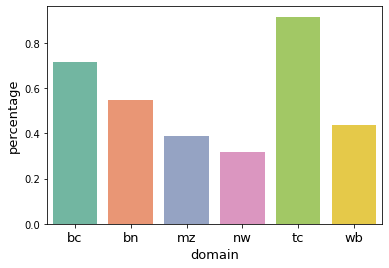

In [145]:
counts_below_per_domain = [ (sum(np.array(sent_len_per_domain[i]) <= np.mean( np.median( total_seq_len ) ) )) / len(sent_len_per_domain[i]) 
                           for i, d in enumerate(domains) ]
print(counts_below_per_domain)

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=domains, y=counts_below_per_domain, ax=ax)
ax.set_xlabel('domain', fontsize=13)
ax.set_ylabel('percentage', fontsize=13)
ax.xaxis.set_tick_params(labelsize=13)
plt.show()


## Range Seq Len (NW/TC)

In [175]:
sent_len_all_domain = cal_sent_len('pool', ['train', 'valid', 'test'])

sent_len_all_domain.describe()


count    112511.000000
mean         21.126059
std          14.927234
min           2.000000
25%          10.000000
50%          18.000000
75%          29.000000
max         298.000000
dtype: float64

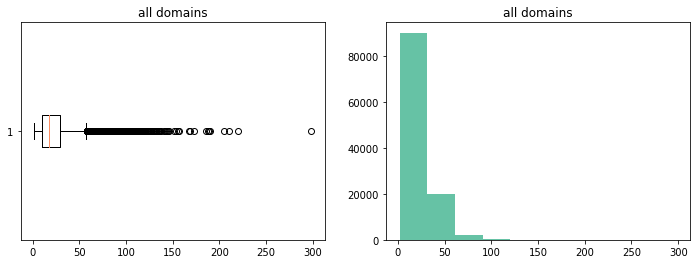

In [176]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].boxplot(x=sent_len_all_domain, vert=False)
ax[0].set_title('all domains')

# ax[1].hist(x=sent_len_all_domain[ sent_len_all_domain > 100])
ax[1].hist(x=sent_len_all_domain)
ax[1].set_title('all domains')
plt.show()


In [238]:
19*1.5+29

57.5

In [239]:
seq_len_range = [2, 6, 10, 58, 9999]


In [240]:
def plot_counts_by_seq_len(sent_len_all_domain, sen_len_threshold, domain='all domains'):
    x_label = []
    sen_len_counts_by_threshold = np.zeros(len(sen_len_threshold) - 1)
        
    for i, v in enumerate(sen_len_threshold[:-1]):
        next_v = sen_len_threshold[ i + 1 ]
        range_sent_len = sent_len_all_domain[ 
            (sent_len_all_domain < next_v) & (sent_len_all_domain >= v)
        ]
        x_label.append('[{}, {})'.format(v, next_v))
        sen_len_counts_by_threshold[i] = len(range_sent_len) / len(sent_len_all_domain)

    print('counts', sen_len_counts_by_threshold)

    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(x=x_label, y=sen_len_counts_by_threshold)
    ax.set_ylabel('Counts', fontsize=13)
    ax.set_xlabel('Threshold of sent_len {}'.format(domain), fontsize=13)
    plt.show()


counts [0.1104692  0.11970385 0.74432722 0.02549973]


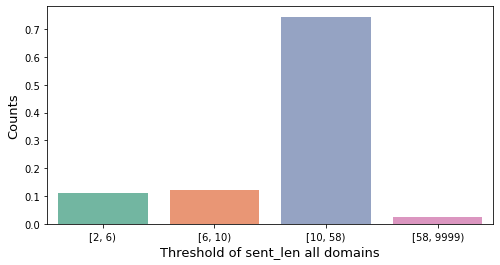

In [241]:
plot_counts_by_seq_len(sent_len_all_domain, seq_len_range)


counts [0.02957998 0.05408646 0.87617613 0.04015743]


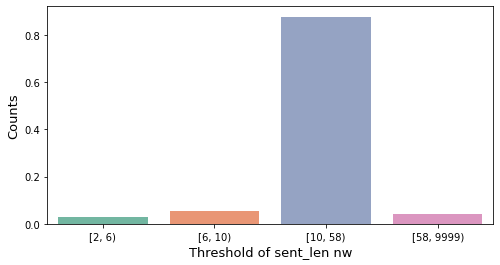

In [242]:
plot_counts_by_seq_len(np.array( sent_len_per_domain[-3] ), seq_len_range, domains[-3])


counts [0.42662177 0.25921659 0.31300957 0.00115207]


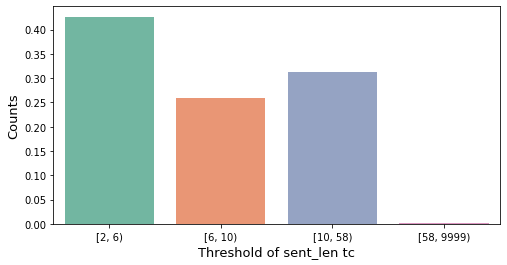

In [243]:
plot_counts_by_seq_len(np.array( sent_len_per_domain[-2] ), seq_len_range, domains[-2])


# 2. Exper II - Seq len

,"[2,6)","[6,10)","[10,58)","[58,9999)"
nw,42.1053,80.4598,76.4594,71.6564
tc,75.0000,67.8571,64.7887,75.0000


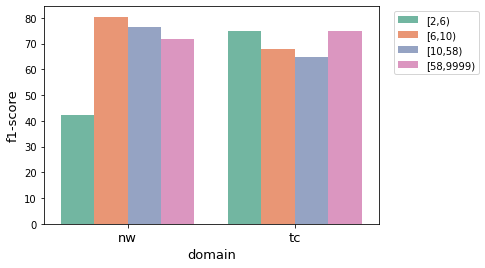

In [281]:
def get_seq_len_f1_score(seq_len_range):
    seq_len_f1 = []
    domains = ['nw', 'tc']
    for d in domains: # each domain
        metric_per_model = [] 
        for t in seq_len_range[:-1]:
            metric_per_model.append( read_score(model='mult', subset=d, subtype='test_sent_' + str(t)) )
        seq_len_f1.append(metric_per_model)

    columns = [ '[{},{})'.format(v, seq_len_range[i+1]) for i, v in enumerate( seq_len_range[:-1] ) ]
    seq_len_f1 = pd.DataFrame(seq_len_f1, columns=columns, index=domains)

    return seq_len_f1

def plot_seq_len_f1_score():
    seq_len_f1_score = get_seq_len_f1_score(seq_len_range)

    seq_len_f1_score_verted = seq_len_f1_score.reset_index()
    seq_len_f1_score_verted = pd.melt(seq_len_f1_score_verted, id_vars=['index'])
    seq_len_f1_score_verted.columns = ['domain', 'seq_len', 'f1-score']

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(x='domain', y='f1-score', hue='seq_len', data=seq_len_f1_score_verted, ax=ax)
    ax.legend(bbox_to_anchor=(1.03, 1), loc=2)
    ax.set_xlabel('domain', fontsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.set_ylabel('f1-score', fontsize=13)


plot_seq_len_f1_score()
get_seq_len_f1_score(seq_len_range)


# Domain Analysis - Rare Word

In [2]:



from wordcloud import WordCloud

def plot_word_cloud(text, size=(8, 8)):
    wordcloud = WordCloud(
        background_color = 'white',
        random_state = 42
    ).generate(text)

    plt.figure( figsize=size )
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


def cal_top_words(words, freqs, n=100, rare=False):
    words = np.array(words)
    freqs = np.array(freqs)


    if rare:
        top_n_words = words[freqs < n]
        top_n_freqs = freqs[freqs < n]
    else:
        top_n_words = words[freqs > n]
        top_n_freqs = freqs[freqs > n]

    top_word_freq = {w: top_n_freqs[i] for i,w in enumerate(top_n_freqs)}

    return top_word_freq, top_n_words, top_n_freqs



stop = stopwords.words('english')
def cal_word_freq(corpus):
    words = []
    for sent in corpus:
        for w in sent.split():
#             w_l = w.lower()
#             if w_l.strip() in stop or w_l in string.punctuation or w_l.isdigit() or w_l in ['\'s', 'said', "n't", '--'] or '0' in w_l:
#                 continue
            words.append(w)

    print('total words ', len(words))
    
    w_freq = nltk.FreqDist(words)

    return {w: q for w, q in w_freq.items()}, np.array(list(w_freq.keys())), np.array(list(w_freq.values()))


# Rare Words

sents with different scarcity of rare words (e.g. contains word <1% occurance freq)


## Data(train/valid/test) from all domains

In [5]:
sents_all_domain = load_sentences('pool', ['train', 'valid', 'test'])

sents_all_domain.shape


(112511, 1)

In [6]:
word_counts, words, freqs = cal_word_freq(sents_all_domain['sentence'].tolist())


total words  2376914


In [7]:
pd.Series(freqs).describe()


count     64318.000000
mean         36.955658
std         913.607124
min           1.000000
25%           1.000000
50%           2.000000
75%           7.000000
max      113154.000000
dtype: float64

## Word cloud

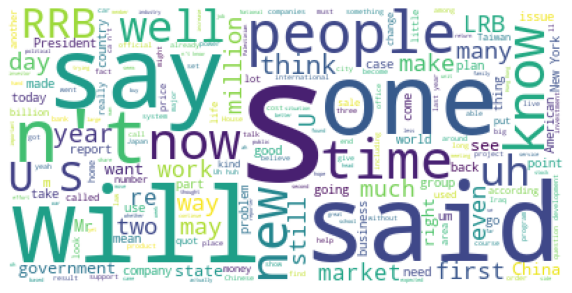

In [8]:
# corpus cloud
plot_word_cloud(' '.join(sents_all_domain['sentence'].tolist()), size=(10, 10))


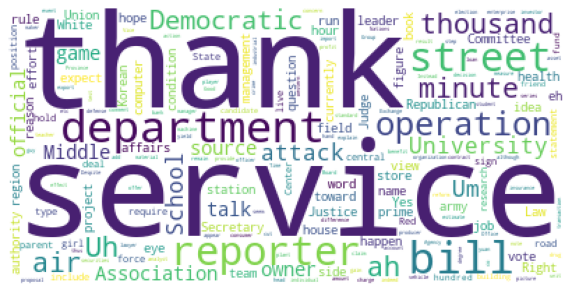

In [9]:
min_freqs = 100
max_freqs = 500
range_words = words[ 
    (freqs <= max_freqs) & (freqs > min_freqs)
]
plot_word_cloud(' '.join(range_words), size=(10, 10))


## Rare word freq (freq<100)

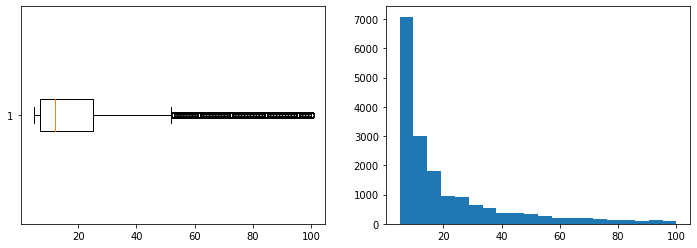

count    17627.000000
mean        20.460260
std         20.197309
min          5.000000
25%          7.000000
50%         12.000000
75%         25.000000
max        100.000000
dtype: float64

In [10]:
rare_freq = freqs[ (freqs <= 100) & (freqs > 4) ]



fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].boxplot(x=rare_freq, vert=False)
ax[1].hist(x=rare_freq, bins=20)
plt.show()

pd.Series(rare_freq).describe()


In [11]:
print('upper IQR: ', (25 - 7) * 1.5 + 25)


upper IQR:  52.0


In [12]:

print([7, 12, 25, 50, 100])


[7, 12, 25, 50, 100]


In [ ]:

def plot_score_by_rare():
    score_by_sent_len = {
        '7': [57.9957,54.271, 50.7846, 43.2939, 54.212],
        '12': [75.0, 70.3971, 53.8813, 53.0323, 66.6667],
        '25': [65.6613, 66.1491, 52.5386, 53.6641,  56.8376],
        '50': [77.0642, 78.6239, 53.4161, 58.1888, 65.4987],
        '100': [76.8519,74.8846, 61.3636, 61.8302, 67.637],
        'common': [96.1538,88.4211,78.2609,84.0,73]
    }
    
    df_score_sent_len = pd.DataFrame(score_by_sent_len)
    df_score_sent_len.index = ['bc', 'bn', 'mz', 'nw', 'wb']
    print(df_score_sent_len)
    
    # plot
    fig, ax = plt.subplots(figsize=(10, 4))
    df_score_sent_len.plot(kind='bar', width=0.8, colormap='tab20c', ax=ax)
    plt.legend(bbox_to_anchor=(1.03, 1), loc=2)
    plt.xticks(range(len(df_score_sent_len.index)), df_score_sent_len.index, rotation=0, fontsize=12)
    ax.set_title('F1_score by rare_ward', fontsize=14)

plot_score_by_rare()


# Sentence Length

## 1. Sent(train/valid/test) from all domains

## 2. 3. Sent(train/valid/test) from In-Domain

## 3. Sent(train/valid/test) from leave-one-out domains

In [8]:
leave_one_domain = 'wb'

sent_len_wo_domain = cal_sent_len('pool_' + leave_one_domain, ['train', 'valid', 'test'])
sent_len_wo_domain.describe()


count    91397.000000
mean        20.676324
std         14.982602
min          2.000000
25%          9.000000
50%         18.000000
75%         28.000000
max        298.000000
dtype: float64

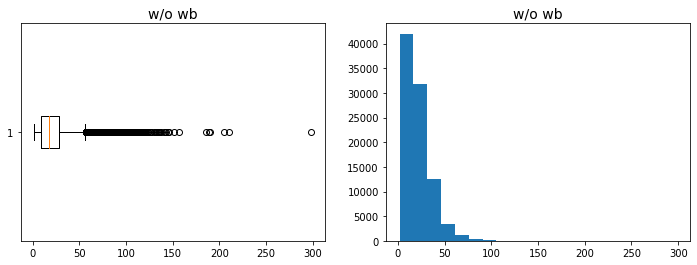

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].boxplot(x=sent_len_wo_domain, vert=False)
ax[0].set_title('w/o ' + leave_one_domain, fontsize=14)

# ax[1].hist(x=sent_len_wo_domain[sent_len_wo_domain<86], bins=20)
ax[1].hist(x=sent_len_wo_domain, bins=20)
ax[1].set_title('w/o ' + leave_one_domain, fontsize=14)

plt.show()


## 4. Threshold of set_len

In [16]:
# 1.5*IQR, 3*IQR
print('upper IQR: ', 29 + 1.5*(29-10))


upper IQR:  57.5


### Counts by threshold (all domains)

In [17]:
# [ 5, 10(25%), 30(75%), 60(1.5IQR), max ]
# sen_len_threshold = [ 5, 10, 30, 60, max(sent_len_all_domain) ]
sen_len_threshold = [ 10, 30, 60, max(sent_len_all_domain) ]

sen_len_threshold


[10, 30, 60, 298]

counts [29295. 59035. 21859.  2322.]


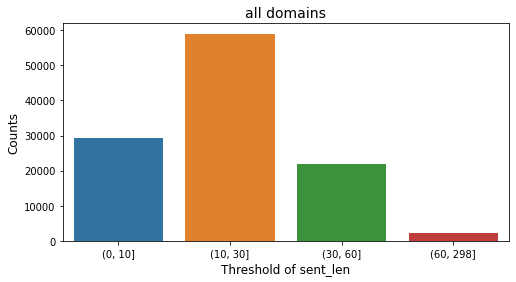

### Hist of sent_len(all domains)

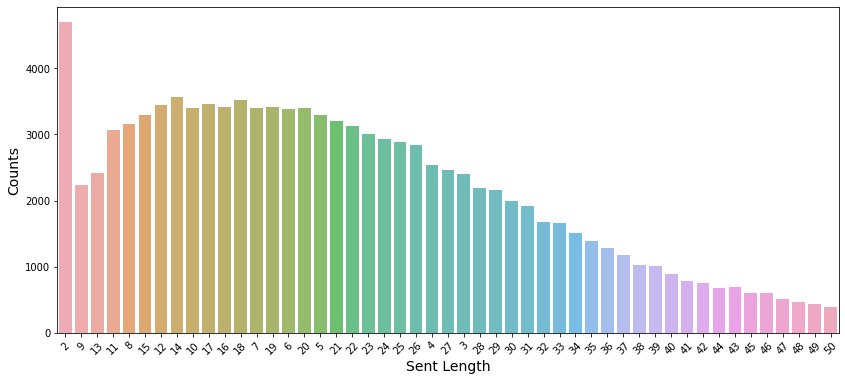

In [24]:
min_len_breakpoint = 0
max_len_breakpoint = 50
top_sent_len = sent_len_all_domain[ 
    (sent_len_all_domain <= max_len_breakpoint) & (sent_len_all_domain > min_len_breakpoint)
].value_counts()

fig, ax = plt.subplots(figsize=(14, 6))
# fig, ax = plt.subplots()
sns.barplot(x=top_sent_len.index, y=top_sent_len.values, alpha=0.8)

# ax.set_title('Distribution of training sentence length from all domains')
ax.set_ylabel('Counts', fontsize=14)
ax.set_xlabel('Sent Length', fontsize=14)
plt.xticks(range(len(top_sent_len.index)), top_sent_len.index, rotation=45)

plt.show()


### Counts by threshold (leave one domains)

In [25]:

# [ 5, 10(25%), 30(75%), 60(1.5IQR), max ]
# sen_len_threshold = [ 5, 10, 30, 60, max(sent_len_wo_domain) ]
one_sen_len_threshold = [ 10, 30, 60, max(sent_len_wo_domain) ]

one_sen_len_threshold


[10, 30, 60, 298]

counts [25774. 46403. 17379.  1841.]


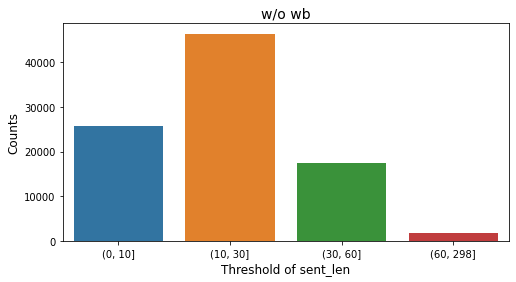

In [28]:
prev_v = 0
one_x_label = []
one_sen_len_counts_by_threshold = np.zeros(len(one_sen_len_threshold))

for i, v in enumerate(one_sen_len_threshold):
    range_sent_len = sent_len_wo_domain[ 
        (sent_len_wo_domain <= v) & (sent_len_wo_domain > prev_v)
    ]

    one_x_label.append('({}, {}]'.format(prev_v, v))

    prev_v = v
    
    one_sen_len_counts_by_threshold[i] = len(range_sent_len)

print('counts', one_sen_len_counts_by_threshold)

# sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=one_x_label, y=one_sen_len_counts_by_threshold)

ax.set_title('w/o ' + leave_one_domain, fontsize=14)
ax.set_ylabel('Counts', fontsize=12)
ax.set_xlabel('Threshold of sent_len', fontsize=12)
plt.show()
